In [7]:
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor 
import regression_common

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

In [48]:
# Create/store/load binary image data
if not os.path.isfile('../data/binary_imgs.npy'):
  
    dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
    img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
    img_filenames.sort()
    print('Number of subjects: %d' % len(img_filenames))
    
    img_shape = load_img(img_filenames[0]).shape
    
    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
    masker = masker.fit()
    
    imgs = masker.transform(img_filenames) # break down into slices if necessary
    imgs = imgs.astype(bool)
    np.save('../data/binary_imgs', imgs)

else:
    imgs = np.load('../data/binary_imgs.npy')
    
imgs.shape

(1401, 228453)

## Multitask analysis with 100 PC components

In [2]:
# Calculate 100 PC components
if not os.path.isfile('../data/binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=100, copy=False)
    X_pc = pca.fit_transform(imgs)
    np.save('../data/binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load('../data/binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [3]:
patient_df = pd.read_hdf('../data/patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))

### Multitask Ridge

In [4]:
def perform_multitask_ridge(X, Y):
    print('Performing Multitask Ridge regression (5-fold nested CV)')
    estimator = MultiTaskElasticNet(l1_ratio=0.001)
    alpha = np.linspace(0, 100, 51)
    my_grid={"alpha": alpha}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [6]:
scores_mr = perform_multitask_ridge(X_pc, Y)

Performing Multitask Ridge regression (5-fold nested CV)

Fold-1: Best params: {'alpha': 54.0}

Fold-2: Best params: {'alpha': 34.0}

Fold-3: Best params: {'alpha': 32.0}

Fold-4: Best params: {'alpha': 22.0}

Fold-5: Best params: {'alpha': 40.0}


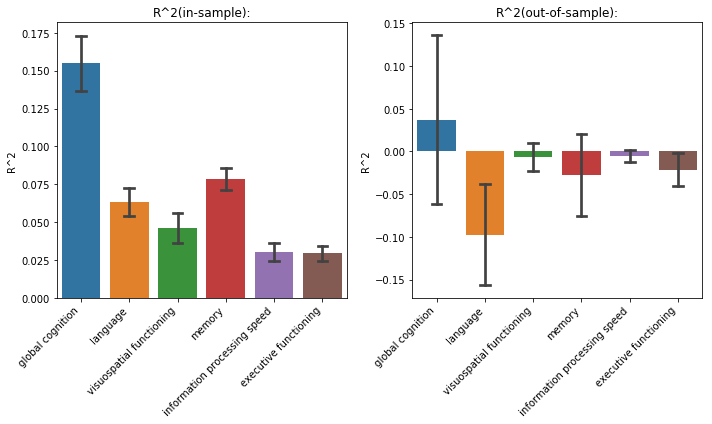

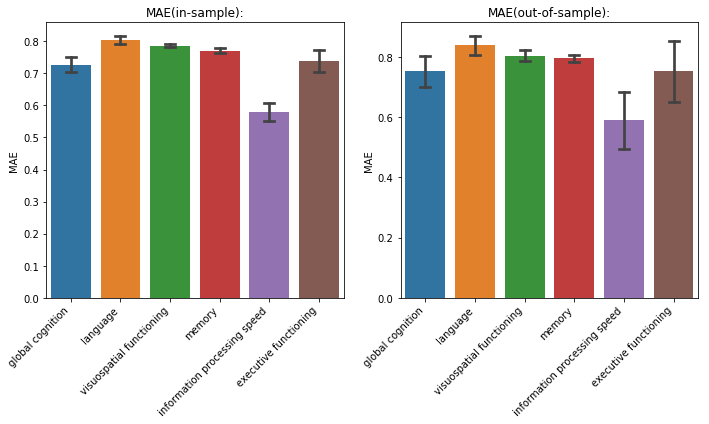

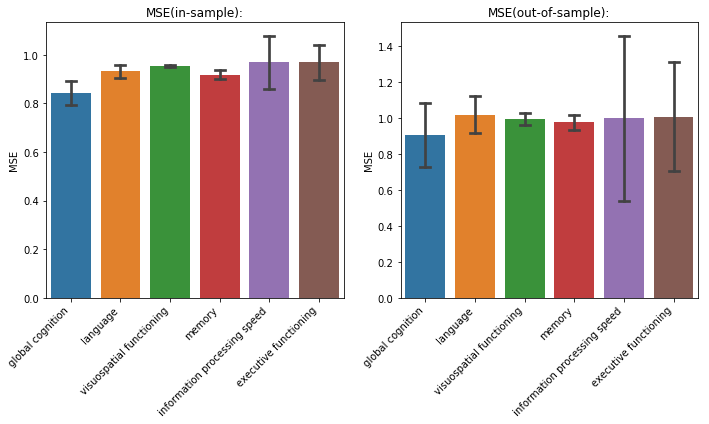

In [8]:
regression_common.display_all_results(scores_mr, plot_only=True)

### Random Forest Regression

In [11]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV)')
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [10, 100, 500, 1000]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [10, 50, 100, None]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    max_samples = [0.4, 0.5, 0.7, 0.8]
    
    my_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
    
    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True)

In [12]:
scores_rf = perform_random_forest_regr(X_pc, Y)

Performing Random Forest regression (5-fold nested CV)

Fold-1: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-2: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-3: Best params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 10}

Fold-4: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-5: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}



R^2 (in-sample):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,mean
global cognition,0.468842,0.479965,0.404597,0.467114,0.460878,0.456279
language,0.384066,0.396909,0.342094,0.387507,0.390845,0.380284
visuospatial functioning,0.339551,0.341409,0.295403,0.377554,0.363008,0.343385
memory,0.363260,0.371391,0.323382,0.359616,0.362874,0.356105
information processing speed,0.300815,0.298923,0.269897,0.333638,0.343055,0.309266
executive functioning,0.288631,0.288923,0.264074,0.340834,0.341009,0.304694



R^2 (out-of-sample):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,mean
global cognition,0.014192,-0.076025,0.062484,0.114308,0.114325,0.045857
language,-0.057006,-0.159201,-0.014424,0.011051,-0.005760,-0.045068
visuospatial functioning,0.021506,0.040394,-0.019965,-0.028953,0.003160,0.003228
memory,-0.058148,-0.052813,0.012562,0.066181,0.024160,-0.001612
information processing speed,0.023935,0.013887,-0.028190,-0.019321,-0.129573,-0.027852
executive functioning,0.020740,0.000806,-0.038741,-0.137538,-0.055821,-0.042111



MAE (in-sample):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,mean
global cognition,0.578359,0.586916,0.587533,0.541804,0.547796,0.568482
language,0.650506,0.654393,0.661455,0.627798,0.638478,0.646526
visuospatial functioning,0.648565,0.643360,0.661419,0.637443,0.630928,0.644343
memory,0.643255,0.638747,0.657016,0.635738,0.640165,0.642984
information processing speed,0.469724,0.458821,0.495370,0.500639,0.496025,0.484116
executive functioning,0.613419,0.587070,0.642403,0.647710,0.628580,0.623836



MAE (out-of-sample):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,mean
global cognition,0.704297,0.629501,0.762673,0.821181,0.775083,0.738547
language,0.812718,0.761825,0.862564,0.845358,0.795767,0.815646
visuospatial functioning,0.792286,0.804309,0.816744,0.790515,0.777606,0.796292
memory,0.768777,0.776451,0.820169,0.789298,0.777307,0.786401
information processing speed,0.643385,0.692539,0.640356,0.494827,0.515378,0.597297
executive functioning,0.794600,0.888432,0.761663,0.650353,0.687065,0.756422



MSE (in-sample):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,mean
global cognition,0.549134,0.571658,0.574594,0.498038,0.516106,0.541906
language,0.619478,0.628086,0.645455,0.589021,0.602958,0.616999
visuospatial functioning,0.657290,0.658289,0.693192,0.635095,0.635598,0.655893
memory,0.637623,0.642542,0.667672,0.624814,0.636808,0.641892
information processing speed,0.657849,0.586811,0.700076,0.739966,0.756879,0.688316
executive functioning,0.677043,0.630101,0.734911,0.723392,0.700744,0.693238



MSE (out-of-sample):


,Fold-1,Fold-2,Fold-3,Fold-4,Fold-5,mean
global cognition,0.807946,0.572409,1.043695,1.108243,0.996569,0.905773
language,0.928010,0.821277,1.084465,1.051247,0.963610,0.969722
visuospatial functioning,0.989752,0.952021,1.068134,0.935965,0.983659,0.985906
memory,0.949968,0.881496,1.020735,0.983910,0.923307,0.951883
information processing speed,1.205914,1.627883,1.193738,0.564681,0.438522,1.006147
executive functioning,1.165925,1.436493,1.043151,0.658643,0.786589,1.018160


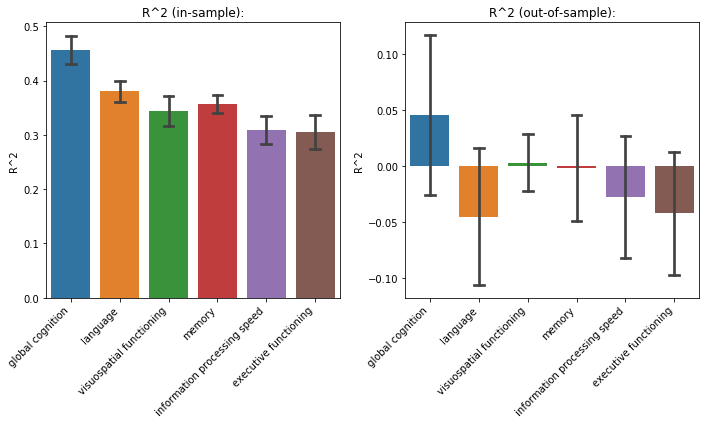

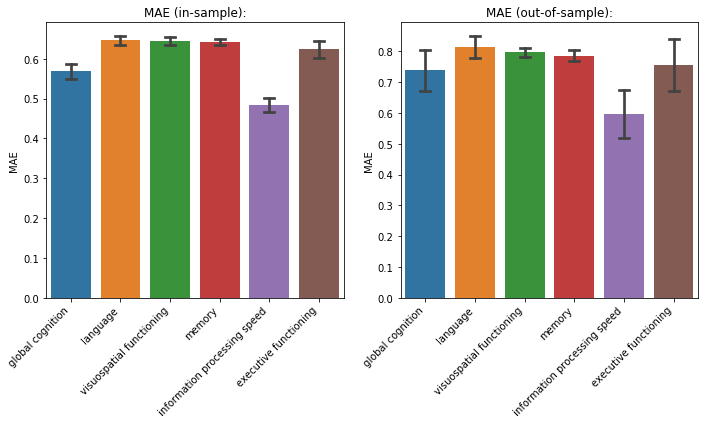

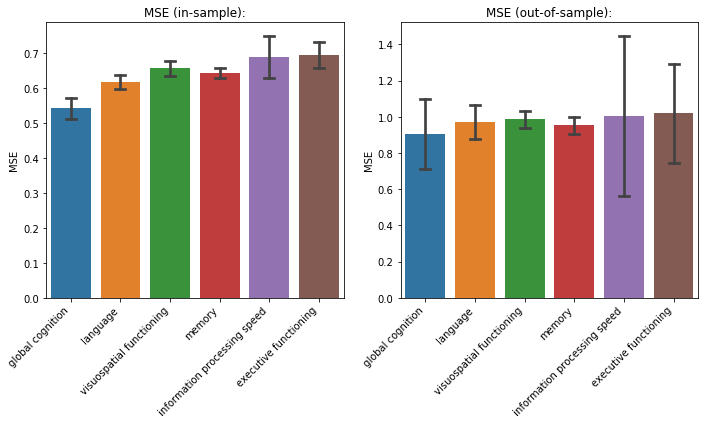

In [14]:
regression_common.display_all_results(scores_rf, plot_only=False)